In [82]:
import numpy as np
import pandas as pd
import pylab as pl
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn import datasets
import matplotlib.pyplot as plt
import sklearn.metrics as sm
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from math import sqrt

## K means for sample data points

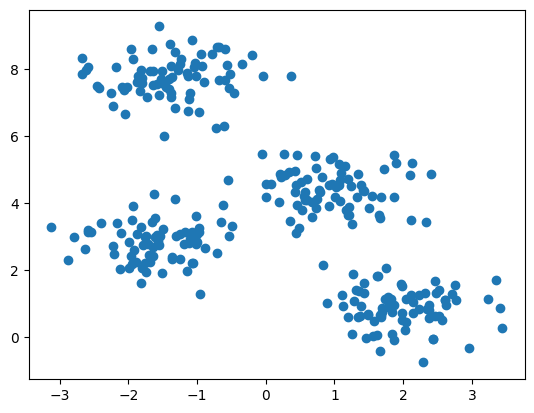

In [83]:
 
X, y = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
 
plt.scatter(X[:,0],X[:,1])
plt.show()

## Elbow curve

In [84]:
from math import sqrt
n = int(sqrt(len(X)))

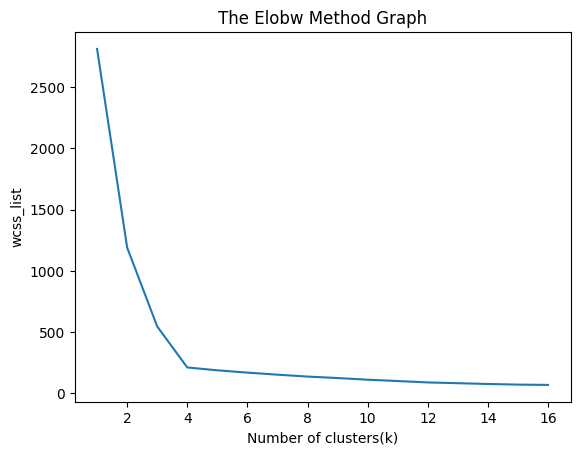

In [85]:
wcss_list = []
for i in range(1, n):  
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state= 42)  
    kmeans.fit(X)  
    wcss_list.append(kmeans.inertia_)  

plt.plot(range(1, n), wcss_list)  
plt.title('The Elobw Method Graph')  
plt.xlabel('Number of clusters(k)')  
plt.ylabel('wcss_list')  
plt.show() 

## To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia starts decreasing in a linear fashion. Thus for the given data, we conclude that the optimal number of clusters for the data is 4.

## Defining functions for each of the different distance measures

In [86]:
import numpy as np

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

def squared_euclidean_distance(x1, x2):
    return np.sum((x1 - x2) ** 2)

def cosine_distance(x1, x2):
    return 1 - np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))

## Function to find clusters whose centroid points have reached convergence state.

In [87]:
import pandas as pd

def find_clusters(X, n_clusters, distance_metric='euclidean', rseed=2):
    # Initialize centroids
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    # Dictionary to store distances
    distance_dict = {}
    
    iteration = 0
    while True:
        # Calculate distances between points and centroids
        if distance_metric == 'euclidean':
            distances = np.array([[euclidean_distance(x, c) for c in centers] for x in X])
        elif distance_metric == 'manhattan':
            distances = np.array([[manhattan_distance(x, c) for c in centers] for x in X])
        elif distance_metric == 'squared_euclidean':
            distances = np.array([[squared_euclidean_distance(x, c) for c in centers] for x in X])
        elif distance_metric == 'cosine':
            distances = np.array([[cosine_distance(x, c) for c in centers] for x in X])
        else:
            raise ValueError("Invalid distance metric specified")

        # Assign labels based on closest center
        labels = np.argmin(distances, axis=1)
        
        # Store distances in dictionary
        for idx, distance in enumerate(distances):
            distance_dict[idx] = [distance[idx] for idx, _ in enumerate(distance)]
            distance_dict[idx].append(np.min(distance))
            distance_dict[idx].append(labels[idx])

        # Store distances in DataFrame
        df = pd.DataFrame.from_dict(distance_dict, orient='index', columns=['Centroid 1', 'Centroid 2', 'Centroid 3', 'Centroid 4', 'Minimum Value', 'Cluster'])
        print(df)
        # Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
        print(new_centers)
        # Display centroids and points for each iteration
        plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
        plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
        plt.title(f'Iteration {iteration} for {distance_metric}')
        plt.show()
        
        # Increment iteration counter
        iteration += 1

        # Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels, df

## Functions to check for silhoutte scores and Sum of squared errors

In [88]:
def silhouette_score(X, labels):
    n_samples = len(X)
    cluster_labels = np.unique(labels)
    n_clusters = len(cluster_labels)
    
    # Calculate distance matrix
    distance_matrix = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            distance_matrix[i, j] = euclidean_distance(X[i], X[j])
    
    silhouette_scores = np.zeros(n_samples)
    for i in range(n_samples):
        a = 0  # Average distance to points in the same cluster
        b = np.inf  # Minimum average distance to points in other clusters
        
        cluster_idx = labels[i]
        for j in range(n_samples):
            if labels[j] == cluster_idx and i != j:
                a += distance_matrix[i, j]
        if np.sum(labels == cluster_idx) > 1:
            a /= np.sum(labels == cluster_idx) - 1
        
        for k in range(n_clusters):
            if k != cluster_idx:
                b_k = 0
                for j in range(n_samples):
                    if labels[j] == k:
                        b_k += distance_matrix[i, j]
                b_k /= np.sum(labels == k)
                b = min(b, b_k)
        
        silhouette_scores[i] = (b - a) / max(a, b)
    
    # Calculate silhouette score for each cluster
    cluster_silhouette_scores = []
    for cluster_idx in cluster_labels:
        cluster_points = X[labels == cluster_idx]
        cluster_score = np.mean(silhouette_scores[labels == cluster_idx])
        cluster_silhouette_scores.append(cluster_score)
    
    # Calculate overall silhouette score
    overall_score = np.mean(silhouette_scores)
    
    return overall_score, cluster_silhouette_scores



In [89]:
def calculate_sse(X, centers, labels):
    sse = 0
    for i, center in enumerate(centers):
        cluster_points = X[labels == i]
        sse += np.sum((cluster_points - center) ** 2)
    return sse

## Euclidean Distance Measure

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0      3.381052    6.050025    2.545704    2.322841       2.322841        3
1      2.570033    0.362546    3.211487    3.550988       0.362546        1
2      0.957350    3.674928    1.198357    2.110873       0.957350        0
3      2.676850    0.354296    3.428775    3.886304       0.354296        1
4      3.714274    6.443268    2.927575    2.790987       2.790987        3
..          ...         ...         ...         ...            ...      ...
295    4.245914    7.035130    3.536418    3.509559       3.509559        3
296    4.655742    7.469607    4.002863    4.044743       4.002863        2
297    0.948772    3.705213    0.358859    1.206001       0.358859        2
298    2.323175    1.739606    3.236519    3.965590       1.739606        1
299    3.414597    5.037523    2.610030    1.680533       1.680533        3

[300 rows x 6 columns]
[[ 0.996244    5.28262763]
 [-1.39262004  7.7943098 ]
 [ 1.26533

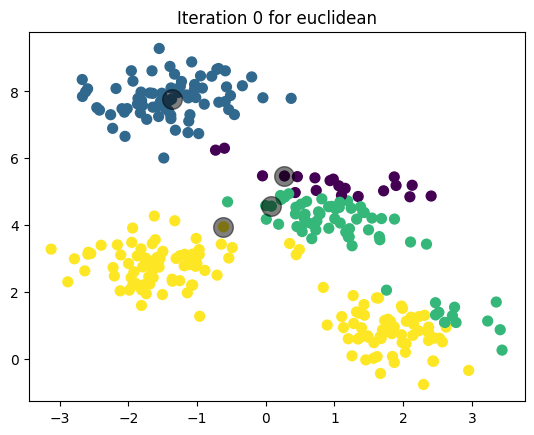

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0      3.150303    6.081363    1.579457    0.895377       0.895377        3
1      3.214302    0.385261    4.611108    5.646739       0.385261        1
2      0.242412    3.708478    1.447229    3.382356       0.242412        0
3      3.236069    0.374571    4.744276    5.962855       0.374571        1
4      3.401230    6.475153    1.764054    1.307282       1.307282        3
..          ...         ...         ...         ...            ...      ...
295    3.829668    7.067690    2.194269    2.039914       2.039914        3
296    4.177988    7.502545    2.588324    2.610496       2.588324        2
297    0.931714    3.737893    1.206688    2.645096       0.931714        0
298    2.585594    1.762102    4.230463    5.871375       1.762102        1
299    3.766585    5.060383    3.188496    1.936480       1.936480        3

[300 rows x 6 columns]
[[ 0.83263592  4.88355267]
 [-1.37324398  7.75368871]
 [ 1.27651

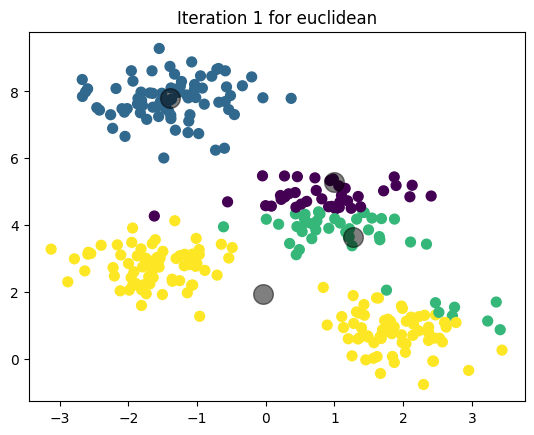

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0      2.747197    6.036467    1.429846    0.821699       0.821699        3
1      3.380365    0.346431    4.748278    5.764713       0.346431        1
2      0.388253    3.665676    1.607268    3.435953       0.388253        0
3      3.466990    0.359874    4.890048    6.074096       0.359874        1
4      3.023014    6.430157    1.604400    1.201798       1.201798        3
..          ...         ...         ...         ...            ...      ...
295    3.495256    7.022744    2.039970    1.920576       1.920576        3
296    3.877393    7.457781    2.444151    2.488187       2.444151        2
297    0.525166    3.692989    1.334523    2.721657       0.525166        0
298    2.944211    1.743124    4.388919    5.959297       1.743124        1
299    3.382207    5.021466    3.157663    2.072807       2.072807        3

[300 rows x 6 columns]
[[ 0.73354867  4.69619738]
 [-1.37324398  7.75368871]
 [ 1.57053

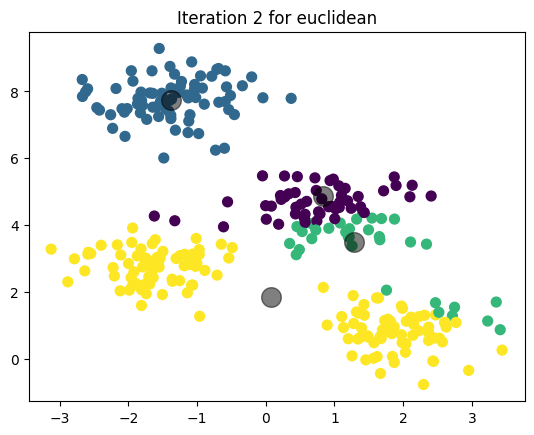

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0      2.561922    6.036467    1.278111    0.818526       0.818526        3
1      3.460228    0.346431    5.174016    5.783226       0.346431        1
2      0.583566    3.665676    1.961182    3.448459       0.583566        0
3      3.577217    0.359874    5.306515    6.092115       0.359874        1
4      2.854771    6.430157    1.324606    1.192627       1.192627        3
..          ...         ...         ...         ...            ...      ...
295    3.354089    7.022744    1.653037    1.908469       1.653037        2
296    3.755629    7.457781    2.026466    2.475397       2.026466        2
297    0.335337    3.692989    1.763812    2.736659       0.335337        0
298    3.116248    1.743124    4.762135    5.975267       1.743124        1
299    3.188202    5.021466    3.389793    2.089084       2.089084        3

[300 rows x 6 columns]
[[ 0.68610507  4.58014816]
 [-1.37324398  7.75368871]
 [ 1.99353

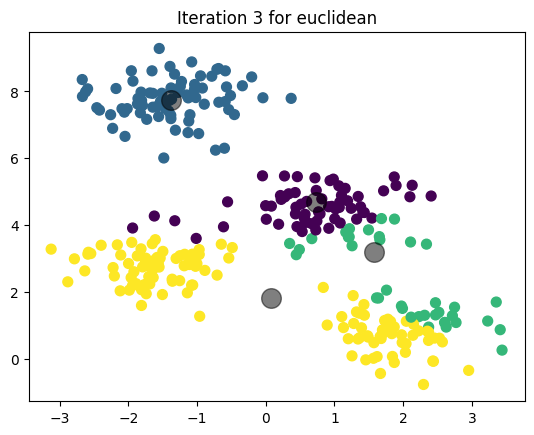

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0      2.448434    6.036467    1.167198    1.026230       1.026230        3
1      3.523483    0.346431    6.147495    5.693147       0.346431        1
2      0.699937    3.665676    2.929417    3.494637       0.699937        0
3      3.656472    0.359874    6.290288    6.019506       0.359874        1
4      2.750589    6.430157    0.825645    1.422740       0.825645        2
..          ...         ...         ...         ...            ...      ...
295    3.264964    7.022744    0.713194    2.142845       0.713194        2
296    3.677346    7.457781    1.042658    2.709775       1.042658        2
297    0.251040    3.692989    2.729214    2.741885       0.251040        0
298    3.226530    1.743124    5.733222    5.955622       1.743124        1
299    3.080417    5.021466    3.812476    1.867024       1.867024        3

[300 rows x 6 columns]
[[ 0.78282981  4.46904474]
 [-1.37324398  7.75368871]
 [ 2.03698

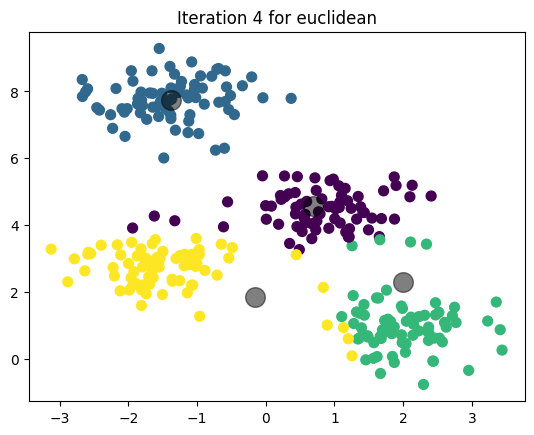

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0      2.333311    6.036467    1.651132    2.291842       1.651132        2
1      3.670363    0.346431    7.277349    4.761148       0.346431        1
2      0.732320    3.665676    4.191057    3.538631       0.732320        0
3      3.800007    0.359874    7.466421    5.180251       0.359874        1
4      2.622407    6.430157    1.174137    2.773398       1.174137        2
..          ...         ...         ...         ...            ...      ...
295    3.125046    7.022744    0.580885    3.536090       0.580885        2
296    3.532937    7.457781    0.619139    4.112119       0.619139        2
297    0.350284    3.692989    3.878094    2.633124       0.350284        0
298    3.347678    1.743124    6.990528    5.437545       1.743124        1
299    3.095676    5.021466    4.208327    0.407195       0.407195        3

[300 rows x 6 columns]
[[ 0.92914792  4.41289231]
 [-1.37324398  7.75368871]
 [ 1.98258

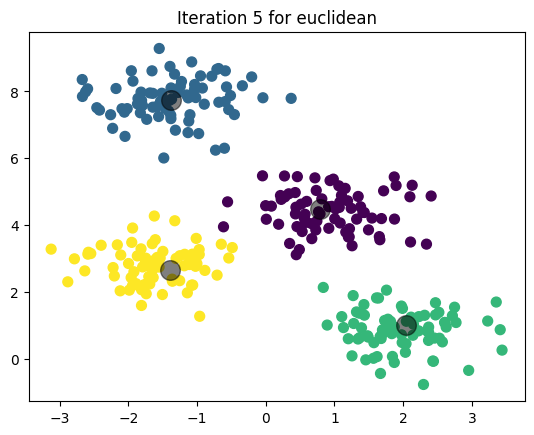

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0      2.278403    6.036467    1.709430    2.527354       1.709430        2
1      3.803832    0.346431    7.370959    4.597606       0.346431        1
2      0.722979    3.665676    4.312026    3.576823       0.722979        0
3      3.920146    0.359874    7.567748    5.032624       0.359874        1
4      2.543476    6.430157    1.247447    3.013708       1.247447        2
..          ...         ...         ...         ...            ...      ...
295    3.019521    7.022744    0.712141    3.778993       0.712141        2
296    3.413611    7.457781    0.749446    4.355181       0.749446        2
297    0.505364    3.692989    3.979759    2.665791       0.505364        0
298    3.424259    1.743124    7.108830    5.350109       1.743124        1
299    3.188731    5.021466    4.217243    0.204901       0.204901        3

[300 rows x 6 columns]
[[ 0.94973532  4.41906906]
 [-1.37324398  7.75368871]
 [ 1.98258

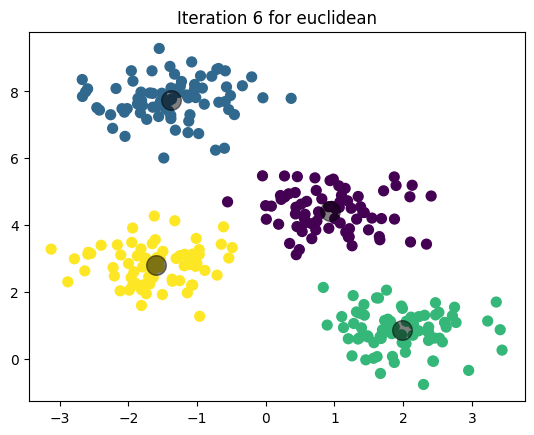

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0      2.285499    6.036467    1.709430    2.518864       1.709430        2
1      3.811698    0.346431    7.370959    4.581992       0.346431        1
2      0.710893    3.665676    4.312026    3.557088       0.710893        0
3      3.925070    0.359874    7.567748    5.016111       0.359874        1
4      2.546915    6.430157    1.247447    3.005924       1.247447        2
..          ...         ...         ...         ...            ...      ...
295    3.018270    7.022744    0.712141    3.771603       0.712141        2
296    3.409559    7.457781    0.749446    4.347783       0.749446        2
297    0.523944    3.692989    3.979759    2.646029       0.523944        0
298    3.421597    1.743124    7.108830    5.331237       1.743124        1
299    3.209523    5.021466    4.217243    0.222404       0.222404        3

[300 rows x 6 columns]
[[ 0.94973532  4.41906906]
 [-1.37324398  7.75368871]
 [ 1.98258

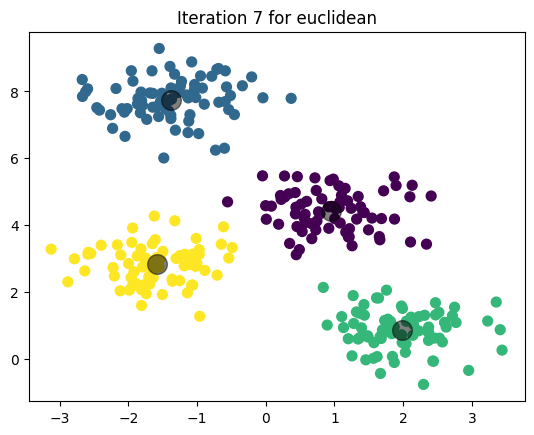

In [90]:
centers, labels, df = find_clusters(X, 4, distance_metric='euclidean')


## Silhoutte Score for Euclidean Distance measure


In [91]:
# Calculate silhouette score for the clustering
overall_silhouette_score, cluster_silhouette_scores = silhouette_score(X, labels)

print("Overall Silhouette Score:", overall_silhouette_score)
print("Cluster Silhouette Scores:", cluster_silhouette_scores)
sse = calculate_sse(X, centers, labels)
print(f"SSE using Euclidean distance measure: {sse}")

Overall Silhouette Score: 0.6819938690643477
Cluster Silhouette Scores: [0.6328521983760572, 0.7197605036768113, 0.7141883173608394, 0.6611744568436829]
SSE using Euclidean distance measure: 212.00599621083478


## Manhattan Distance Measure

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0      3.898061    7.840022    3.186404    3.265040       3.186404        2
1      3.625717    0.403571    4.337375    4.258738       0.403571        1
2      1.253158    5.195118    1.605894    2.920103       1.253158        0
3      3.635967    0.396762    4.347624    4.268988       0.396762        1
4      4.576373    8.518334    3.864716    3.943352       3.864716        2
..          ...         ...         ...         ...            ...      ...
295    5.591463    9.533423    4.879806    4.958442       4.879806        2
296    6.324140   10.266100    5.612483    5.691119       5.612483        2
297    1.100625    5.042586    0.388968    1.640190       0.388968        2
298    2.418228    1.761047    3.511646    4.825855       1.761047        1
299    4.784145    5.441325    3.690726    2.376517       2.376517        3

[300 rows x 6 columns]
[[ 0.78292844  5.3602494 ]
 [-1.39262004  7.7943098 ]
 [ 1.52060

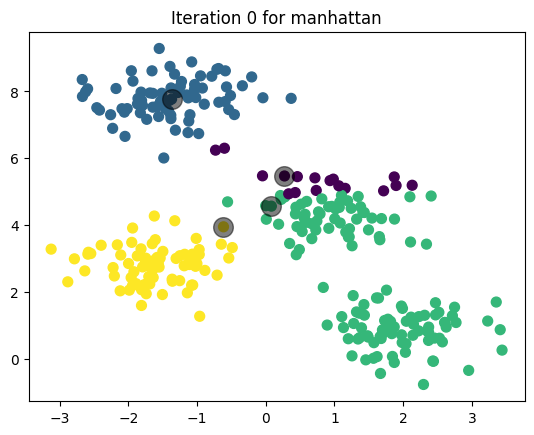

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0      3.277818    7.887427    0.902402    3.115695       0.902402        2
1      4.245960    0.405725    7.988878    4.749537       0.405725        1
2      0.632915    5.242524    3.110003    5.008404       0.632915        0
3      4.256210    0.394609    7.999128    5.549870       0.394609        1
4      3.956130    8.565739    0.711725    3.794007       0.711725        2
..          ...         ...         ...         ...            ...      ...
295    4.971220    9.580829    1.228302    4.809097       1.228302        2
296    5.703897   10.313506    1.960979    5.541773       1.960979        2
297    1.168259    5.089991    3.262536    3.728491       1.168259        0
298    2.844306    1.765303    6.587223    6.914156       1.765303        1
299    5.184966    5.443478    3.706723    0.288217       0.288217        3

[300 rows x 6 columns]
[[ 0.83975124  4.62111681]
 [-1.37324398  7.75368871]
 [ 1.87229

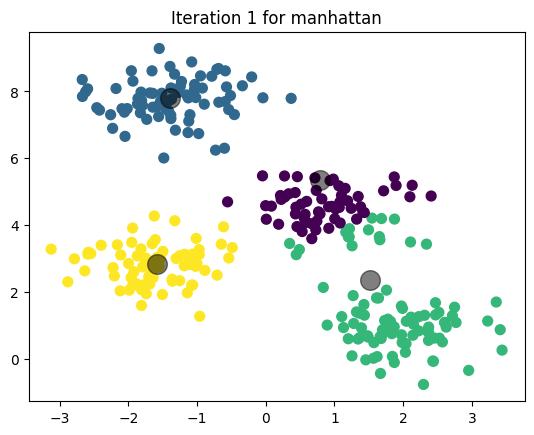

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0      2.487652    7.827430    1.810665    3.115695       1.810665        2
1      5.041916    0.384480    9.334444    4.749537       0.384480        1
2      0.793964    5.182527    4.455568    5.008404       0.793964        0
3      5.052165    0.415854    9.344693    5.549870       0.415854        1
4      3.160175    8.505742    1.132353    3.794007       1.132353        2
..          ...         ...         ...         ...            ...      ...
295    4.175265    9.520832    0.320075    4.809097       0.320075        2
296    4.907941   10.253508    0.676687    5.541773       0.676687        2
297    0.485949    5.029994    4.608101    3.728491       0.485949        0
298    3.640261    1.780139    7.932789    6.914156       1.780139        1
299    4.502657    5.422233    5.052289    0.288217       0.288217        3

[300 rows x 6 columns]
[[ 0.91487488  4.44525863]
 [-1.37324398  7.75368871]
 [ 1.98880

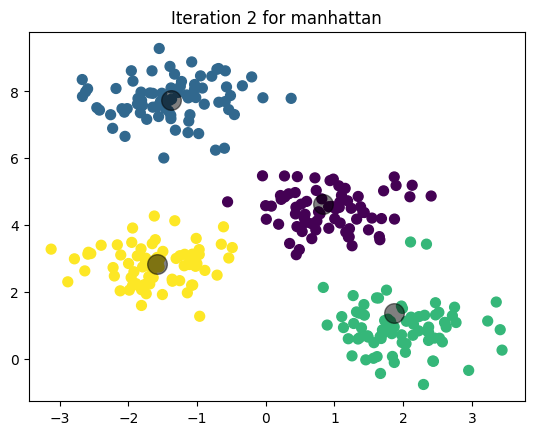

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0      2.386917    7.827430    2.353181    3.115695       2.353181        2
1      5.292898    0.384480    9.876959    4.749537       0.384480        1
2      0.894698    5.182527    4.998084    5.008404       0.894698        0
3      5.303147    0.415854    9.887209    5.549870       0.415854        1
4      2.909193    8.505742    1.674869    3.794007       1.674869        2
..          ...         ...         ...         ...            ...      ...
295    3.924283    9.520832    0.659779    4.809097       0.659779        2
296    4.656959   10.253508    0.986176    5.541773       0.986176        2
297    0.566555    5.029994    5.150617    3.728491       0.566555        0
298    3.891243    1.780139    8.475305    6.914156       1.780139        1
299    4.401922    5.422233    5.594805    0.288217       0.288217        3

[300 rows x 6 columns]
[[ 0.92914792  4.41289231]
 [-1.37324398  7.75368871]
 [ 1.98258

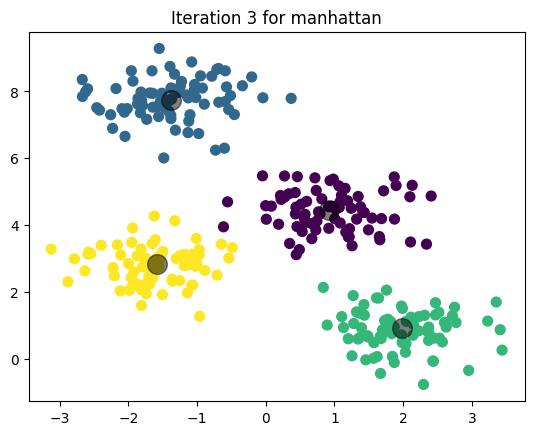

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0      2.368824    7.827430    2.414372    3.113677       2.368824        0
1      5.339537    0.384480    9.938151    4.777757       0.384480        1
2      0.912792    5.182527    5.059276    5.036624       0.912792        0
3      5.349787    0.415854    9.948401    5.578091       0.415854        1
4      2.862554    8.505742    1.736060    3.791988       1.736060        2
..          ...         ...         ...         ...            ...      ...
295    3.877644    9.520832    0.720970    4.807078       0.720970        2
296    4.610320   10.253508    1.059812    5.539755       1.059812        2
297    0.613194    5.029994    5.211808    3.756711       0.613194        0
298    3.937882    1.780139    8.536496    6.942376       1.780139        1
299    4.383829    5.422233    5.655996    0.259996       0.259996        3

[300 rows x 6 columns]
[[ 0.92794934  4.38332695]
 [-1.37324398  7.75368871]
 [ 1.99806

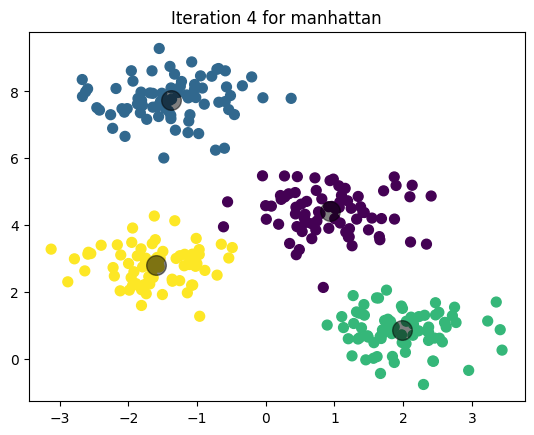

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0      2.338060    7.827430    2.446999    3.113677       2.338060        0
1      5.367904    0.384480    9.970778    4.777757       0.384480        1
2      0.943556    5.182527    5.091902    5.036624       0.943556        0
3      5.378153    0.415854    9.981027    5.578091       0.415854        1
4      2.834187    8.505742    1.768687    3.791988       1.768687        2
..          ...         ...         ...         ...            ...      ...
295    3.849277    9.520832    0.753597    4.807078       0.753597        2
296    4.581953   10.253508    1.061473    5.539755       1.061473        2
297    0.641561    5.029994    5.244435    3.756711       0.641561        0
298    3.966249    1.780139    8.569123    6.942376       1.780139        1
299    4.353065    5.422233    5.688623    0.259996       0.259996        3

[300 rows x 6 columns]
[[ 0.92794934  4.38332695]
 [-1.37324398  7.75368871]
 [ 1.99806

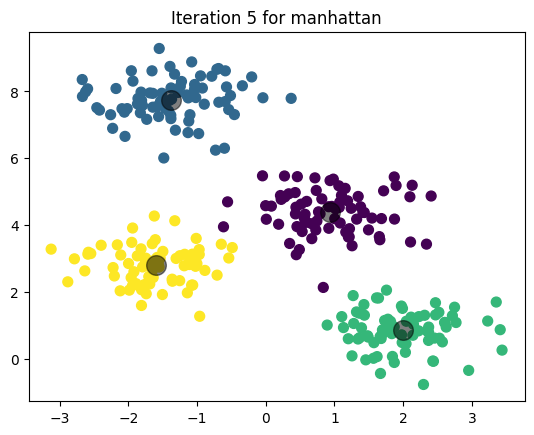

In [92]:
centers, labels, df = find_clusters(X, 4, distance_metric='manhattan')

## Silhoutte score and SSE for manhattan distance measure

In [93]:
# Calculate silhouette score for the clustering
overall_silhouette_score, cluster_silhouette_scores = silhouette_score(X, labels)

print("Overall Silhouette Score:", overall_silhouette_score)
print("Cluster Silhouette Scores:", cluster_silhouette_scores)
sse = calculate_sse(X, centers, labels)
print(f"SSE using Manhattan distance measure: {sse}")

Overall Silhouette Score: 0.6789822520077599
Cluster Silhouette Scores: [0.6062056556989013, 0.7213384185377961, 0.7221386286388323, 0.6686243270797873]
SSE using Manhattan distance measure: 214.58015201142894


## Squared Euclidean Distance Measure

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0     11.431509   36.602805    6.480608    5.395590       5.395590        3
1      6.605072    0.131440   10.313650   12.609516       0.131440        1
2      0.916518   13.505097    1.436059    4.455786       0.916518        0
3      7.165525    0.125526   11.756496   15.103361       0.125526        1
4     13.795831   41.515696    8.570694    7.789606       7.789606        3
..          ...         ...         ...         ...            ...      ...
295   18.027784   49.493054   12.506250   12.317004      12.317004        3
296   21.675938   55.795031   16.022915   16.359946      16.022915        2
297    0.900168   13.728602    0.128780    1.454439       0.128780        2
298    5.397140    3.026230   10.475054   15.725902       3.026230        1
299   11.659475   25.376640    6.812256    2.824192       2.824192        3

[300 rows x 6 columns]
[[ 0.996244    5.28262763]
 [-1.39262004  7.7943098 ]
 [ 1.26533

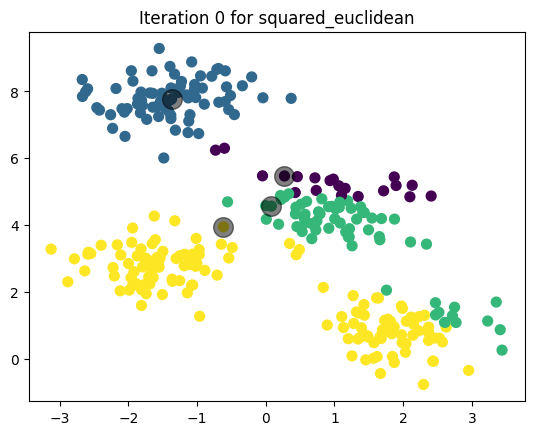

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0      9.924408   36.982970    2.494685    0.801699       0.801699        3
1     10.331738    0.148426   21.262317   31.885664       0.148426        1
2      0.058763   13.752812    2.094473   11.440329       0.058763        0
3     10.472140    0.140303   22.508152   35.555642       0.140303        1
4     11.568364   41.927606    3.111886    1.708987       1.708987        3
..          ...         ...         ...         ...            ...      ...
295   14.666359   49.952246    4.814817    4.161249       4.161249        3
296   17.455585   56.288188    6.699423    6.814691       6.699423        2
297    0.868091   13.971842    1.456097    6.996535       0.868091        0
298    6.685295    3.105002   17.896818   34.473040       3.105002        1
299   14.187160   25.607473   10.166504    3.749956       3.749956        3

[300 rows x 6 columns]
[[ 0.83263592  4.88355267]
 [-1.37324398  7.75368871]
 [ 1.27651

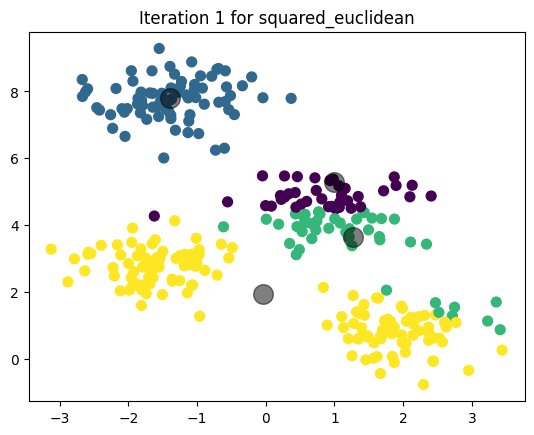

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0      7.547089   36.438934    2.044459    0.675189       0.675189        3
1     11.426869    0.120014   22.546145   33.231912       0.120014        1
2      0.150741   13.437181    2.583312   11.805770       0.150741        0
3     12.020018    0.129509   23.912565   36.894646       0.129509        1
4      9.138616   41.346925    2.574100    1.444318       1.444318        3
..          ...         ...         ...         ...            ...      ...
295   12.216814   49.318939    4.161478    3.688613       3.688613        3
296   15.034178   55.618499    5.973876    6.191073       5.973876        2
297    0.275799   13.638171    1.780951    7.407416       0.275799        0
298    8.668376    3.038482   19.262614   35.513226       3.038482        1
299   11.439326   25.215116    9.970835    4.296527       4.296527        3

[300 rows x 6 columns]
[[ 0.73354867  4.69619738]
 [-1.37324398  7.75368871]
 [ 1.57053

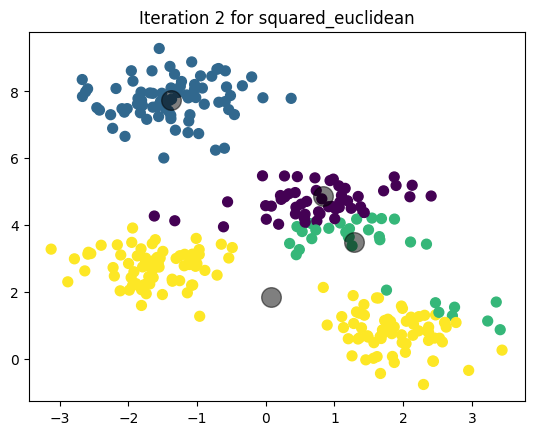

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0      6.563443   36.438934    1.633567    0.669984       0.669984        3
1     11.973177    0.120014   26.770444   33.445701       0.120014        1
2      0.340550   13.437181    3.846235   11.891869       0.340550        0
3     12.796480    0.129509   28.159097   37.113871       0.129509        1
4      8.149715   41.346925    1.754580    1.422359       1.422359        3
..          ...         ...         ...         ...            ...      ...
295   11.249912   49.318939    2.732532    3.642254       2.732532        2
296   14.104752   55.618499    4.106563    6.127588       4.106563        2
297    0.112451   13.638171    3.111032    7.489300       0.112451        0
298    9.711001    3.038482   22.677927   35.703818       3.038482        1
299   10.164630   25.215116   11.490695    4.364270       4.364270        3

[300 rows x 6 columns]
[[ 0.68610507  4.58014816]
 [-1.37324398  7.75368871]
 [ 1.99353

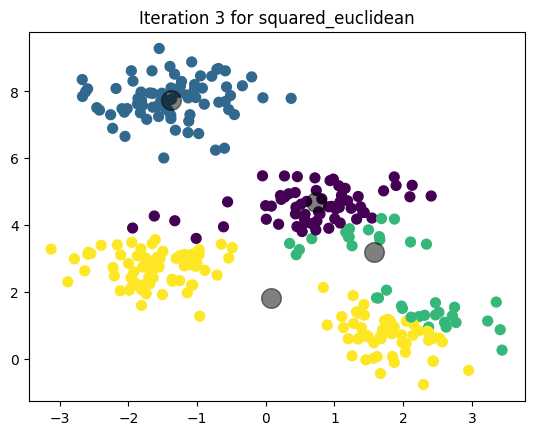

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0      5.994830   36.438934    1.362352    1.053149       1.053149        3
1     12.414935    0.120014   37.791694   32.411918       0.120014        1
2      0.489912   13.437181    8.581482   12.212489       0.489912        0
3     13.369789    0.129509   39.567722   36.234447       0.129509        1
4      7.565740   41.346925    0.681689    2.024190       0.681689        2
..          ...         ...         ...         ...            ...      ...
295   10.659993   49.318939    0.508646    4.591783       0.508646        2
296   13.522871   55.618499    1.087135    7.342881       1.087135        2
297    0.063021   13.638171    7.448609    7.517931       0.063021        0
298   10.410498    3.038482   32.869832   35.469438       3.038482        1
299    9.488971   25.215116   14.534973    3.485777       3.485777        3

[300 rows x 6 columns]
[[ 0.78282981  4.46904474]
 [-1.37324398  7.75368871]
 [ 2.03698

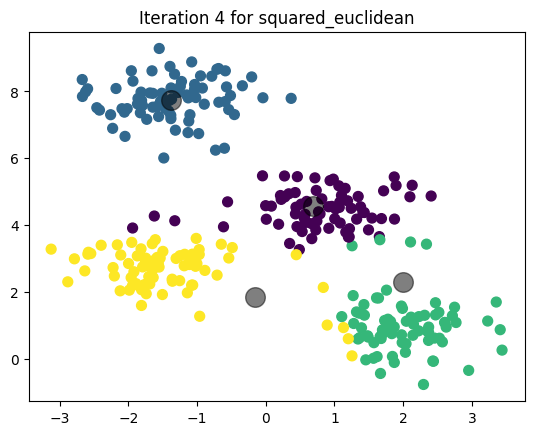

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0      5.444340   36.438934    2.726236    5.252541       2.726236        2
1     13.471561    0.120014   52.959810   22.668534       0.120014        1
2      0.536293   13.437181   17.564956   12.521907       0.536293        0
3     14.440054    0.129509   55.747441   26.834997       0.129509        1
4      6.877019   41.346925    1.378598    7.691735       1.378598        2
..          ...         ...         ...         ...            ...      ...
295    9.765910   49.318939    0.337427   12.503934       0.337427        2
296   12.481646   55.618499    0.383333   16.909523       0.383333        2
297    0.122699   13.638171   15.039614    6.933341       0.122699        0
298   11.206945    3.038482   48.867480   29.566900       3.038482        1
299    9.583209   25.215116   17.710020    0.165808       0.165808        3

[300 rows x 6 columns]
[[ 0.92914792  4.41289231]
 [-1.37324398  7.75368871]
 [ 1.98258

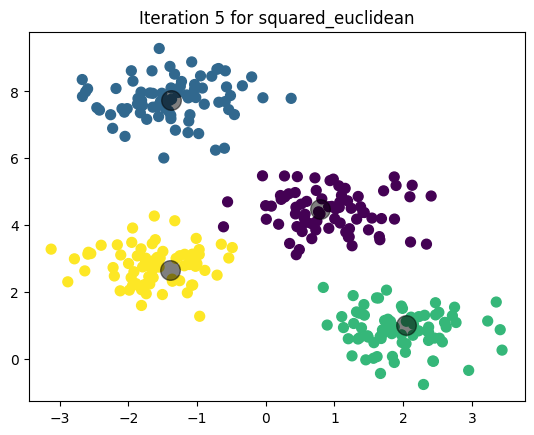

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0      5.191120   36.438934    2.922151    6.387518       2.922151        2
1     14.469136    0.120014   54.331040   21.137984       0.120014        1
2      0.522699   13.437181   18.593567   12.793666       0.522699        0
3     15.367542    0.129509   57.270805   25.327303       0.129509        1
4      6.469269   41.346925    1.556124    9.082435       1.556124        2
..          ...         ...         ...         ...            ...      ...
295    9.117505   49.318939    0.507144   14.280787       0.507144        2
296   11.652741   55.618499    0.561669   18.967605       0.561669        2
297    0.255393   13.638171   15.838485    7.106444       0.255393        0
298   11.725552    3.038482   50.535463   28.623672       3.038482        1
299   10.168006   25.215116   17.785139    0.041984       0.041984        3

[300 rows x 6 columns]
[[ 0.94973532  4.41906906]
 [-1.37324398  7.75368871]
 [ 1.98258

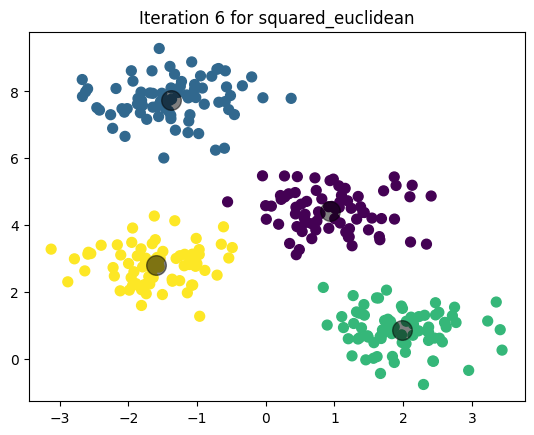

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0      5.223505   36.438934    2.922151    6.344676       2.922151        2
1     14.529043    0.120014   54.331040   20.994654       0.120014        1
2      0.505369   13.437181   18.593567   12.652877       0.505369        0
3     15.406175    0.129509   57.270805   25.161367       0.129509        1
4      6.486776   41.346925    1.556124    9.035580       1.556124        2
..          ...         ...         ...         ...            ...      ...
295    9.109956   49.318939    0.507144   14.224987       0.507144        2
296   11.625089   55.618499    0.561669   18.903220       0.561669        2
297    0.274517   13.638171   15.838485    7.001467       0.274517        0
298   11.707326    3.038482   50.535463   28.422084       3.038482        1
299   10.301035   25.215116   17.785139    0.049463       0.049463        3

[300 rows x 6 columns]
[[ 0.94973532  4.41906906]
 [-1.37324398  7.75368871]
 [ 1.98258

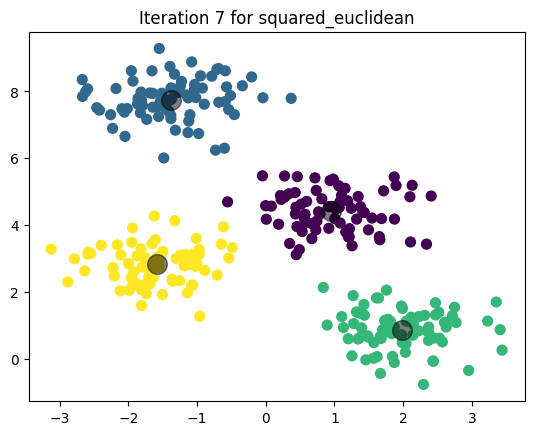

In [94]:
centers, labels, df = find_clusters(X, 4, distance_metric='squared_euclidean')

## Silhoutte score and SSE for Square euclidean distance measure

In [95]:
# Calculate silhouette score for the clustering
overall_silhouette_score, cluster_silhouette_scores = silhouette_score(X, labels)

print("Overall Silhouette Score:", overall_silhouette_score)
print("Cluster Silhouette Scores:", cluster_silhouette_scores)
sse = calculate_sse(X, centers, labels)
print(f"SSE using Square Euclidean distance measure: {sse}")

Overall Silhouette Score: 0.6819938690643477
Cluster Silhouette Scores: [0.6328521983760572, 0.7197605036768113, 0.7141883173608394, 0.6611744568436829]
SSE using Square Euclidean distance measure: 212.00599621083478


## Cosine Distance Measure

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0      0.051900    0.146371    0.062529    0.136081       0.051900        0
1      0.028254    0.000098    0.021218    0.000580       0.000098        1
2      0.014929    0.077893    0.020924    0.070307       0.014929        0
3      0.016044    0.001009    0.010852    0.000308       0.000308        3
4      0.143202    0.279353    0.160091    0.265573       0.143202        0
..          ...         ...         ...         ...            ...      ...
295    0.337046    0.520166    0.361271    0.502640       0.337046        0
296    0.473368    0.675634    0.500759    0.656699       0.473368        0
297    0.001091    0.036500    0.003090    0.031317       0.001091        0
298    0.000003    0.024524    0.000436    0.020300       0.000003        0
299    0.190325    0.080075    0.172012    0.088136       0.080075        1

[300 rows x 6 columns]
[[ 1.51238874  2.60825026]
 [-1.688423    4.57040963]
 [-0.21047

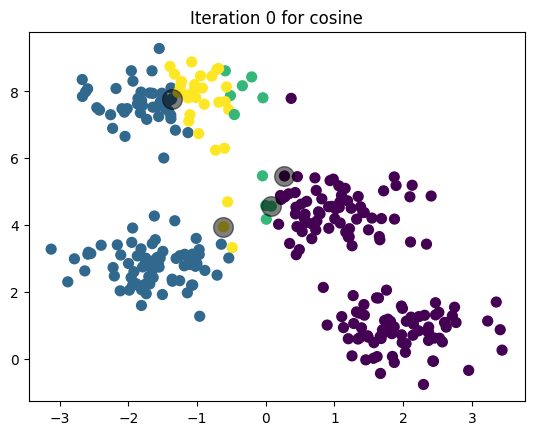

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0      0.011548    0.252977    0.080800    0.119840       0.011548        0
1      0.244246    0.013640    0.012318    0.002262       0.002262        3
2      0.045465    0.161703    0.032128    0.058593       0.032128        2
3      0.207002    0.025042    0.004819    0.000035       0.000035        3
4      0.002181    0.414582    0.187828    0.243450       0.002181        0
..          ...         ...         ...         ...            ...      ...
295    0.067791    0.684364    0.399923    0.474118       0.067791        0
296    0.142522    0.849570    0.544020    0.625712       0.142522        0
297    0.090614    0.099707    0.008166    0.023609       0.008166        2
298    0.112121    0.079431    0.003102    0.014185       0.003102        2
299    0.549000    0.024887    0.145411    0.102264       0.024887        1

[300 rows x 6 columns]
[[ 1.88545088  1.73760849]
 [-1.7473522   3.65605154]
 [ 0.47654

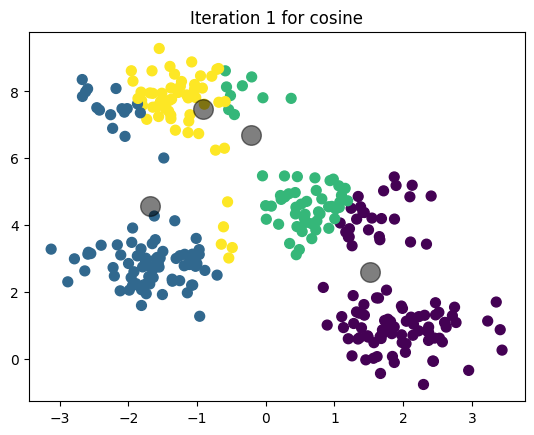

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0      0.100789    0.317186    0.038745    0.140699       0.038745        2
1      0.472128    0.032924    0.039664    0.000312       0.000312        3
2      0.176596    0.215315    0.008270    0.073696       0.008270        2
3      0.423039    0.049585    0.024913    0.000576       0.000576        3
4      0.027405    0.491510    0.121201    0.271778       0.027405        0
..          ...         ...         ...         ...            ...      ...
295    0.002422    0.772840    0.304532    0.510553       0.002422        0
296    0.028600    0.940997    0.436226    0.665258       0.028600        0
297    0.254626    0.143486    0.000003    0.033617       0.000003        2
298    0.288239    0.119191    0.001089    0.022164       0.001089        2
299    0.833604    0.008647    0.217118    0.084439       0.008647        1

[300 rows x 6 columns]
[[ 2.00396233  0.9193214 ]
 [-1.76405203  3.24596534]
 [ 0.89870

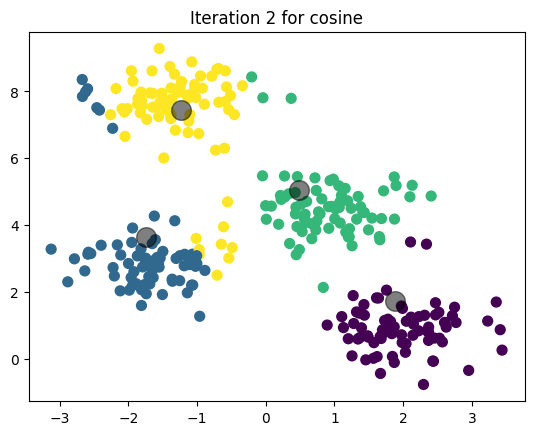

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0      0.280240    0.356058    0.015878    0.144248       0.015878        2
1      0.760756    0.047449    0.072613    0.000163       0.000163        3
2      0.392525    0.248575    0.000388    0.076318       0.000388        2
3      0.704006    0.067022    0.052197    0.000834       0.000834        3
4      0.147037    0.536925    0.077627    0.276524       0.077627        2
..          ...         ...         ...         ...            ...      ...
295    0.029837    0.823733    0.235729    0.516581       0.029837        0
296    0.002794    0.992931    0.355945    0.671767       0.002794        0
297    0.497413    0.171453    0.004840    0.035413       0.004840        2
298    0.540444    0.144974    0.010862    0.023632       0.010862        2
299    1.146801    0.003169    0.283728    0.081686       0.003169        1

[300 rows x 6 columns]
[[ 2.00802058  0.83629568]
 [-1.72385031  2.7476038 ]
 [ 1.00411

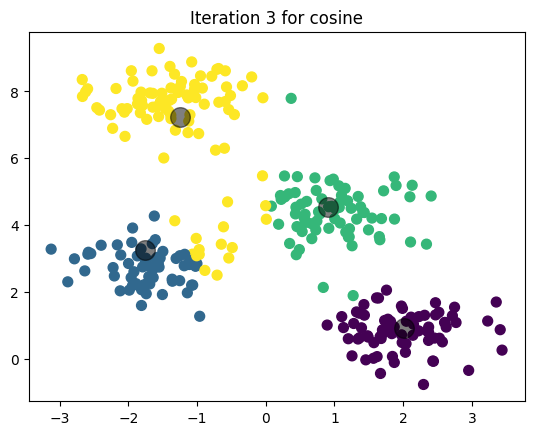

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0      0.305317    0.405115    0.010951    0.148590       0.010951        2
1      0.795347    0.068326    0.084377    0.000047       0.000047        3
2      0.421083    0.291266    0.000003    0.079544       0.000003        2
3      0.738073    0.091331    0.062295    0.001209       0.001209        3
4      0.166089    0.593203    0.066343    0.282303       0.066343        2
..          ...         ...         ...         ...            ...      ...
295    0.039047    0.885575    0.216536    0.523895       0.039047        0
296    0.006071    1.055419    0.333058    0.679652       0.006071        0
297    0.528395    0.208053    0.008276    0.037646       0.008276        2
298    0.572236    0.179043    0.015771    0.025467       0.015771        2
299    1.181795    0.000146    0.305205    0.078418       0.000146        1

[300 rows x 6 columns]
[[ 2.00802058  0.83629568]
 [-1.81002555  2.69678444]
 [ 1.01675

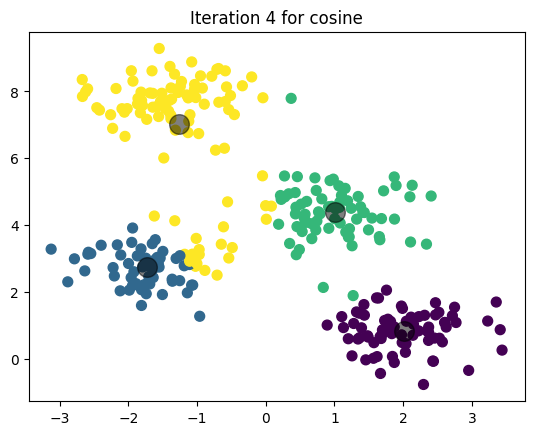

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0      0.305317    0.430147    0.010532    0.151417       0.010532        2
1      0.795347    0.079954    0.085533    0.000010       0.000010        3
2      0.421083    0.313324    0.000014    0.081654       0.000014        2
3      0.738073    0.104618    0.063295    0.001487       0.001487        3
4      0.166089    0.621524    0.065321    0.286050       0.065321        2
..          ...         ...         ...         ...            ...      ...
295    0.039047    0.916218    0.214758    0.528620       0.039047        0
296    0.006071    1.086136    0.330925    0.684739       0.006071        0
297    0.528395    0.227229    0.008648    0.039118       0.008648        2
298    0.572236    0.197014    0.016282    0.026684       0.016282        2
299    1.181795    0.000094    0.307269    0.076349       0.000094        1

[300 rows x 6 columns]
[[ 2.00802058  0.83629568]
 [-1.8338064   2.68708805]
 [ 1.01675

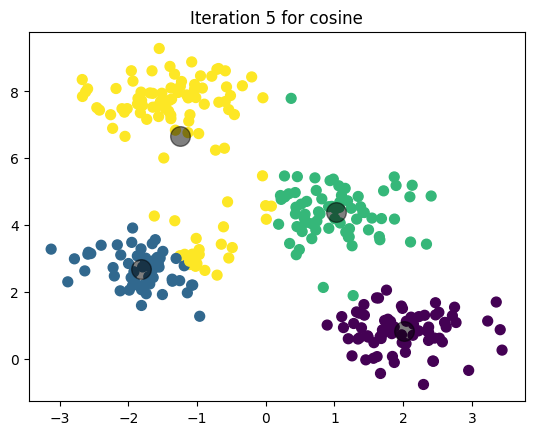

     Centroid 1  Centroid 2  Centroid 3  Centroid 4  Minimum Value  Cluster
0      0.305317    0.436516    0.010532    0.152383       0.010532        2
1      0.795347    0.083011    0.085533    0.000003       0.000003        3
2      0.421083    0.318964    0.000014    0.082377       0.000014        2
3      0.738073    0.108087    0.063295    0.001588       0.001588        3
4      0.166089    0.628691    0.065321    0.287328       0.065321        2
..          ...         ...         ...         ...            ...      ...
295    0.039047    0.923924    0.214758    0.530229       0.039047        0
296    0.006071    1.093836    0.330925    0.686471       0.006071        0
297    0.528395    0.232158    0.008648    0.039624       0.008648        2
298    0.572236    0.201645    0.016282    0.027104       0.016282        2
299    1.181795    0.000229    0.307269    0.075652       0.000229        1

[300 rows x 6 columns]
[[ 2.00802058  0.83629568]
 [-1.8338064   2.68708805]
 [ 1.01675

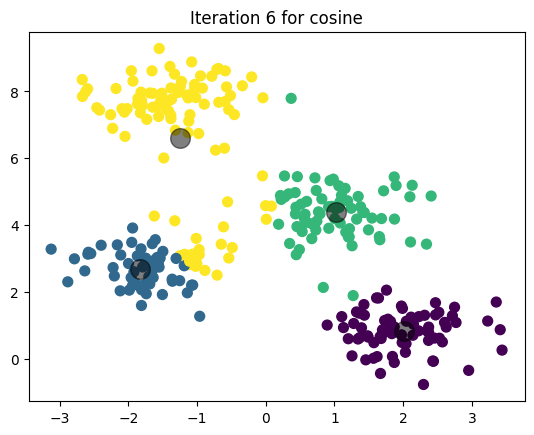

In [96]:
centers, labels, df = find_clusters(X, 4, distance_metric='cosine')

## Silhoutte score and SSE for cosine distance measure

In [97]:
# Calculate silhouette score for the clustering
overall_silhouette_score, cluster_silhouette_scores = silhouette_score(X, labels)

print("Overall Silhouette Score:", overall_silhouette_score)
print("Cluster Silhouette Scores:", cluster_silhouette_scores)
sse = calculate_sse(X, centers, labels)
print(f"SSE using cosine distance measure: {sse}")

Overall Silhouette Score: 0.5265168326456989
Cluster Silhouette Scores: [0.7256496907556395, 0.7359869438483477, 0.6067944730935448, 0.21464671097779012]
SSE using cosine distance measure: 590.3668386928305


# APPLYING K-MEANS FOR IMAGE COMPRESSION

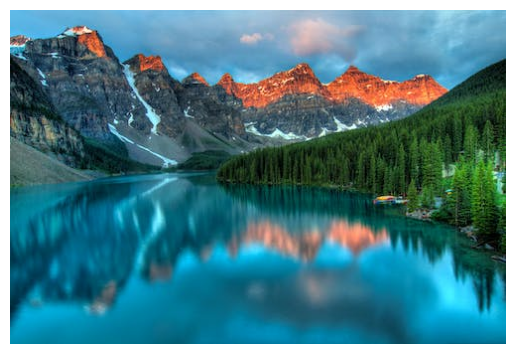

In [98]:
import matplotlib.image as mpimg

# Read the image file
image = mpimg.imread('/kaggle/input/image-compression/high_quality_image.jpeg')

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

In [99]:
image.shape

(337, 500, 3)

## Making the values range from 0 to 1 and decreasing dimensions

In [100]:
data = image / 255.0 # use 0...1 scale
data = data.reshape(337*500, 3)
data.shape

(168500, 3)

In [101]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

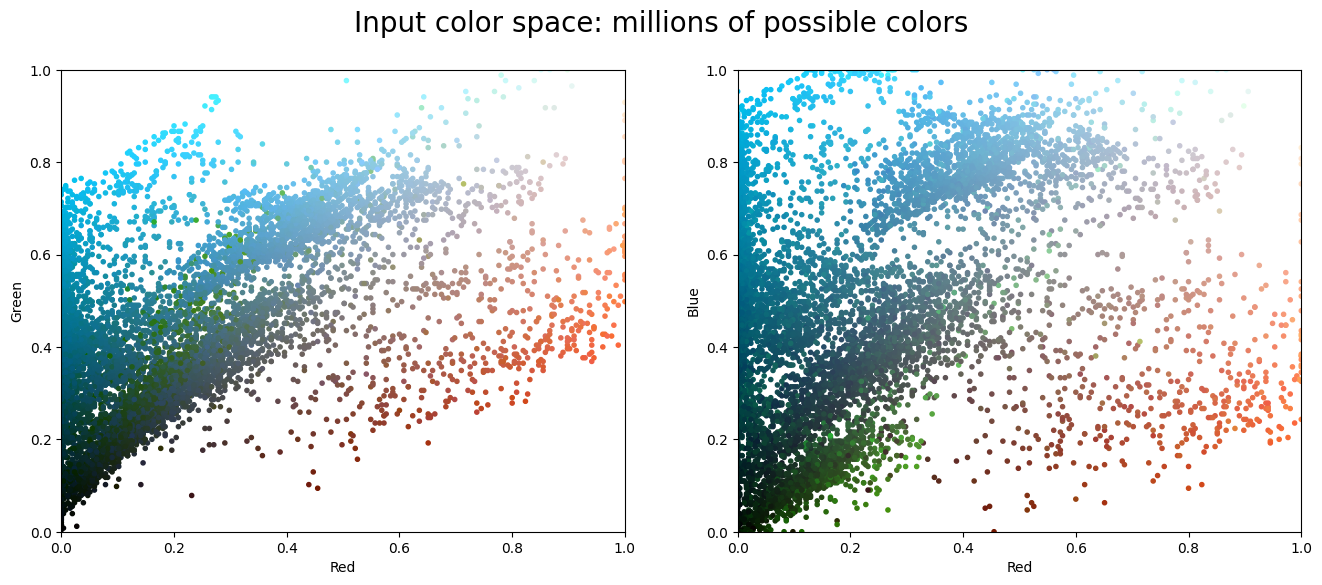

In [102]:
plot_pixels(data, title='Input color space: millions of possible colors')

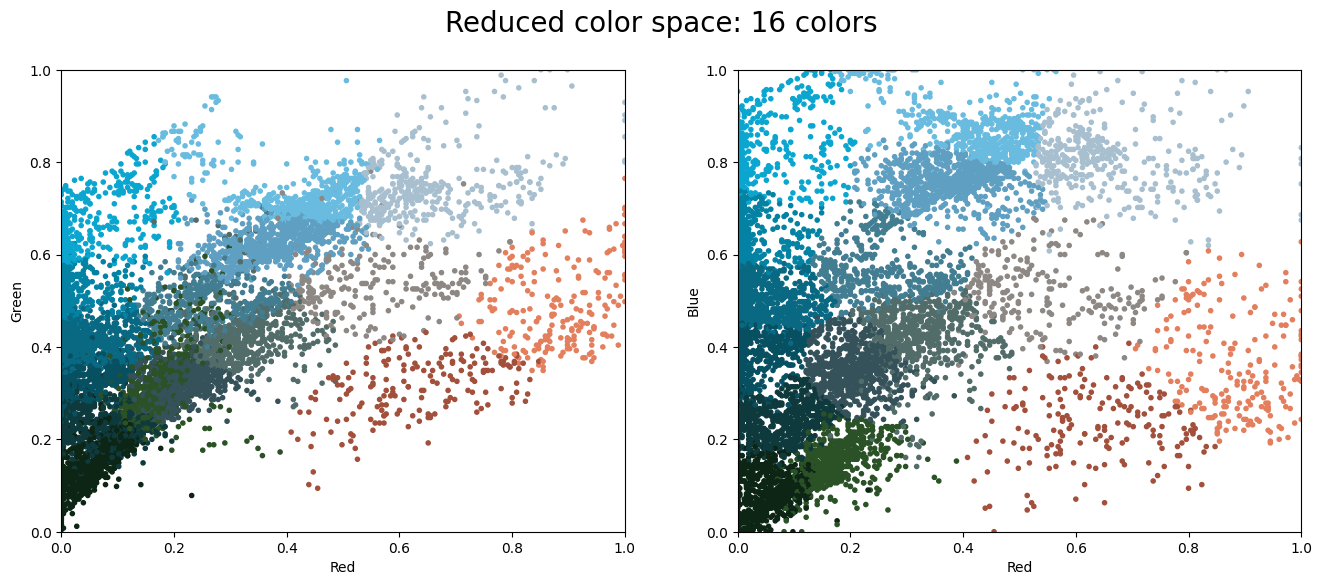

In [103]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

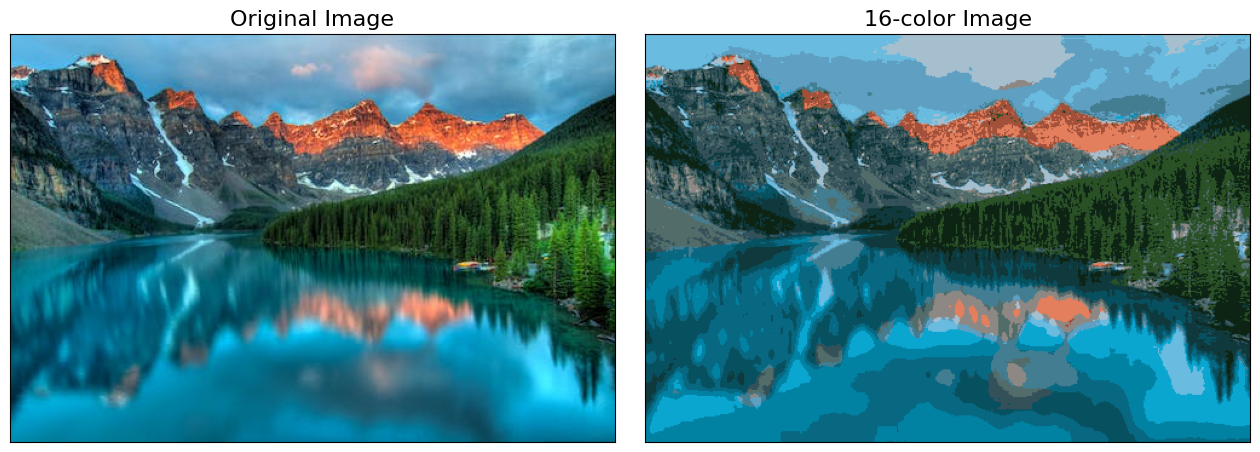

In [104]:
image_recolored = new_colors.reshape(image.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(image)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(image_recolored)
ax[1].set_title('16-color Image', size=16);

In [105]:
from PIL import Image

# Convert image array to PIL image
compressed_image_pil = Image.fromarray((image_recolored * 255).astype(np.uint8))

# Save the compressed image
compressed_image_pil.save('compressed_image.jpeg')

# Check the size of the compressed image
import os
compressed_image_size_kb = os.path.getsize('compressed_image.jpeg') / 1024
original_size = np.round(image.nbytes / 1024, 2)  # in kilobytes
print("Original Image Size:", original_size, "KB")
print("Compressed Image Size:", compressed_image_size_kb, "KB")

Original Image Size: 493.65 KB
Compressed Image Size: 31.0048828125 KB


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

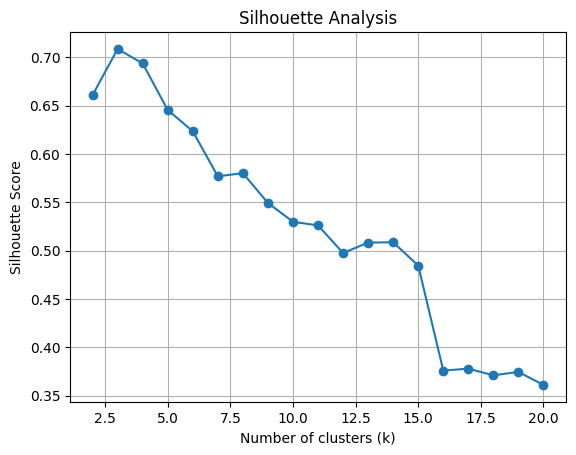

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Read the image file
image = mpimg.imread('/kaggle/input/camel-pa/camel.jpeg')

# Convert image data to float and scale to [0, 1]
data = image / 255.0

# Reshape the data to be a 2D array
data = data.reshape(-1, 3)

# Determine the optimal value of k using silhouette analysis
silhouette_scores = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    silhouette_avg = silhouette_score(data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores for different values of k
plt.plot(range(2, 21), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.grid(True)
plt.show()

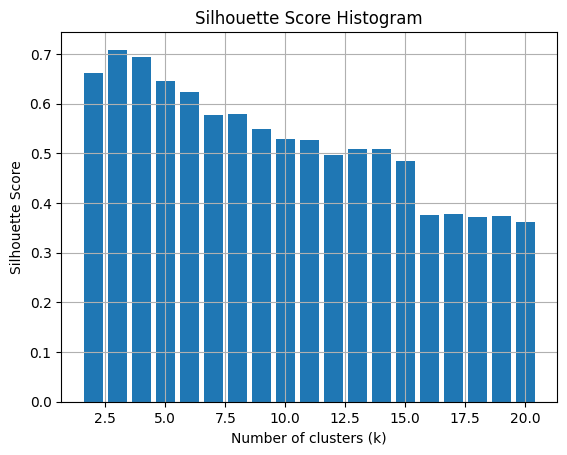

In [12]:
# Plot a histogram of silhouette scores for different values of k
plt.bar(range(2, 21), silhouette_scores)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Histogram')
plt.grid(True)
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

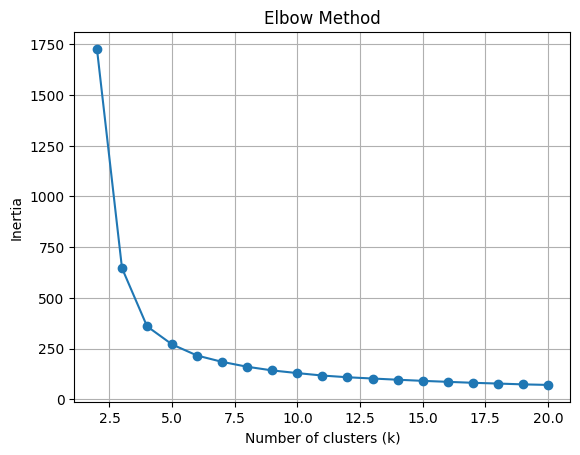

In [13]:
# Determine the optimal value of k using the elbow method
inertia_values = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    inertia_values.append(kmeans.inertia_)

# Plot inertia values for different values of k
plt.plot(range(2, 21), inertia_values, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


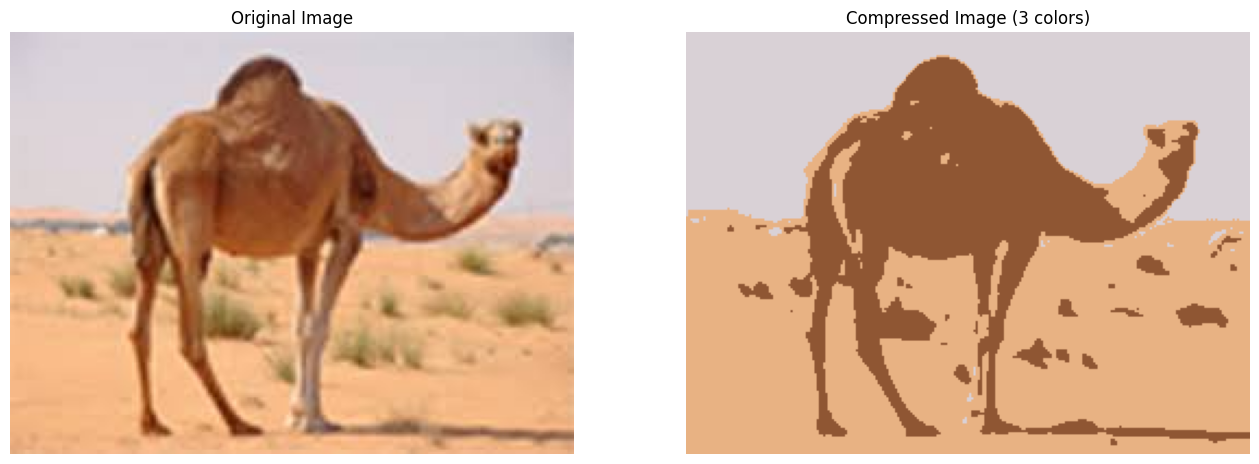

In [14]:

optimal_k = 3  

# Perform KMeans clustering with the optimal value of k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(data)

# Assign each pixel to its nearest centroid
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

# Reshape the clustered data to match the original image shape
image_recolored = new_colors.reshape(image.shape)

# Display the original and compressed images
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(image_recolored)
ax[1].set_title('Compressed Image ({} colors)'.format(optimal_k))
ax[1].axis('off')
plt.show()